Juntamente com conjuntos de dados gigantes e hardware poderoso, excelentes ferramentas de software desempenharam um papel indispensável no rápido progresso do aprendizado profundo.

Começando com a inovadora biblioteca __Theano__ lançada em 2007.

Os pesquisadores de redes neurais passaram da reflexão sobre o comportamento de neurônios artificiais individuais para a concepção de redes em termos de camadas inteiras, e agora muitas vezes projetam arquiteturas com blocos muito mais grosseiros em mente.

Neste capítulo, abriremos a cortina, nos aprofundando nos principais componentes da computação de aprendizado profundo, ou seja, 
- construção de modelo,
- acesso e inicialização de parâmetros,
- projeto de camadas e blocos personalizados,
- leitura e gravação de modelos em disco e
- aproveitamento de GPUs para alcançar melhores resultados.



# 6.1. Camadas e Módulos

Quando começamos a pensar em redes com múltiplas saídas, aproveitamos a aritmética vetorizada para caracterizar uma camada inteira de neurônios.

Assim como os neurônios individuais, as camadas 
- (i) recebem um conjunto de entradas,
- (ii) geram saídas correspondentes e
- (iii) são descritas por um conjunto de parâmetros ajustáveis.

Quando trabalhamos na regressão softmax, uma única camada era o modelo. No entanto, mesmo quando introduzimos posteriormente as MLPs, ainda poderíamos pensar que o modelo mantinha a mesma estrutura básica.

Curiosamente, para MLPs, tanto o modelo inteiro como as suas camadas constituintes partilham esta estrutura. Todo o modelo:
- recebe entradas brutas (os recursos),
- gera saídas (as previsões) e
- possui parâmetros (os parâmetros combinados de todas as camadas constituintes).

Da mesma forma, cada camada individual ingere entradas (fornecidas pela camada anterior), gera saídas (as entradas para a camada subsequente) e possui um conjunto de parâmetros ajustáveis que são atualizados de acordo com o sinal que flui para trás da camada subsequente.

Arquiteturas semelhantes nas quais as camadas são organizadas em vários padrões repetidos são agora onipresentes em outros domínios, incluindo o processamento de linguagem natural e a fala.

Para implementar essas redes complexas, introduzimos o conceito de __módulo__ de rede neural . Um módulo pode descrever uma única camada, um componente que consiste em múltiplas camadas ou o próprio modelo inteiro! 

Ao definir código para gerar módulos de complexidade arbitrária sob demanda, podemos escrever código surpreendentemente compacto e ainda implementar redes neurais complexas.

Do ponto de vista da programação, um __módulo__ é representado por uma __classe__. Qualquer __subclasse__ dela deve definir um __método de propagação direta__ que transforme sua entrada em saída e deve armazenar quaisquer parâmetros necessários. Observe que alguns módulos não requerem nenhum parâmetro. Finalmente um módulo deve possuir um método de __retropropagação__, para fins de cálculo de __gradientes__.


In [1]:
import torch
from torch import nn
from torch.nn import functional as F

O código a seguir gera uma rede com uma camada oculta totalmente conectada com 256 unidades (num_hiddens) e ativação ReLU, seguida por uma camada de saída totalmente conectada com dez (num_outputs) unidades (sem função de ativação).

In [2]:
# net = rede
# A classe Sequential conecta módulos em série.
net = nn.Sequential(nn.LazyLinear(256),  # camada de entrada, com num_hiddens=256
                    nn.ReLU(),           # função de ativação
                    nn.LazyLinear(10))   # camada de saída, com num_outputs=10

X = torch.rand(2, 20)                    # dados de entrada X, com 2 linhas e 20 colunas
net(X).shape

C:\Users\zeh\pythonProject\.venv\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([2, 10])

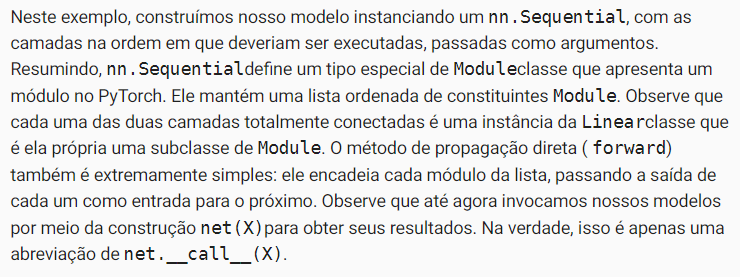

# 6.1.1. Um módulo personalizado

Resumimos brevemente a funcionalidade básica que cada módulo deve fornecer:

- Ingerir dados de entrada como argumentos para seu método de propagação direta.

- Gere uma saída fazendo com que o método de propagação direta retorne um valor. Observe que a saída pode ter um formato diferente da entrada. Por exemplo, a primeira camada (camda de entrada) totalmente conectada em nosso modelo acima ingere uma entrada de dimensão arbitrária, mas retorna uma saída de dimensão 256.

- Calcule o gradiente de sua saída em relação à sua entrada, que pode ser acessado através do método de retropropagação. Normalmente isso acontece automaticamente.

- Armazene e forneça acesso aos parâmetros necessários para executar o cálculo de propagação direta.

- Inicialize os parâmetros do modelo conforme necessário.

No trecho a seguir, codificamos um módulo do zero correspondente a um MLP com uma camada oculta com 256 unidades ocultas e uma camada de saída de 10 dimensões.

Observe que a classe MLP abaixo herda a classe que representa um módulo.

In [4]:
class MLP(nn.Module):
    def __init__(self):
        # Call the constructor of the parent class nn.Module to perform
        # the necessary initialization
        super().__init__()                        # invoca o método __init__() de nn.Module (classe pai): método construtor.
        self.hidden = nn.LazyLinear(256)          # instanciamos a camada de entrada, com num_hiddens=256 (número de neurônios).
        self.out = nn.LazyLinear(10)              # instanciamos a camada de saída, com num_outputs=10.

    # Define the forward propagation of the model, that is, how to return the
    # required model output based on the input X
    def forward(self, X):
        return self.out(F.relu(self.hidden(X)))   # função de ativação (relu) - vem após self.hidden=nn.LazyLinear(256).

Nesta MLP implementação, ambas as camadas são variáveis de instância (self). Para ver por que isso é razoável, imagine instanciar dois MLPs, __net1__ e __net2__, e treiná-los em dados diferentes. Naturalmente, esperaríamos que representassem dois modelos aprendidos diferentes.

Primeiro, nosso método personalizado invoca o método __init__da classe pai, poupando-nos do trabalho de reafirmar o código padrão aplicável à maioria dos módulos.



In [5]:
net = MLP()
net(X).shape

torch.Size([2, 10])

Uma virtude fundamental da abstração do módulo é sua versatilidade. Podemos subclassificar um módulo para criar camadas (como a classe de camada totalmente conectada), modelos inteiros (como a MLP classe acima) ou vários componentes de complexidade intermediária. Exploraremos essa versatilidade nos próximos capítulos, como ao abordar redes neurais convolucionais.

# Código Agrupado #1. Class MLP

In [9]:
import torch
from torch import nn
from torch.nn import functional as F

# --------------------------------------------------------------------------------------------------------------------
class MLP(nn.Module):
    def __init__(self):
        # Call the constructor of the parent class nn.Module to perform
        # the necessary initialization
        super().__init__()                        # invoca o método __init__() de nn.Module (classe pai): método construtor.
        
        self.hidden = nn.LazyLinear(256)          # instanciamos a camada de entrada, com num_hiddens=256 (número de neurônios).
        self.out = nn.LazyLinear(10)              # instanciamos a camada de saída, com num_outputs=10.

    # Define the forward propagation of the model, that is, how to return the
    # required model output based on the input X
    def forward(self, X):
        return self.out(F.relu(self.hidden(X)))   # função de ativação (relu) - vem após self.hidden=nn.LazyLinear(256).


# --------------------------------------------------------------------------------------------------------------------
#Dados de entrada:
X = torch.rand(2, 20)

net = MLP()
# MLP(
#   (hidden): Linear(in_features=20, out_features=256, bias=True)    # camada de entrada    (20x256)
#   (out): Linear(in_features=256, out_features=10, bias=True)       # camada de saída      (256x10)
# )
print(net(X).shape)
# --------------------------------------------------------------------------------------------------------------------


torch.Size([2, 10])


# 6.1.2. O Módulo Sequencial

Lembre-se de que a __classe Sequential__ foi projetada para conectar outros __módulos em série__. Para construir nossa própria classe MySequential simplificada, precisamos apenas definir dois métodos principais:

- Um método para anexar módulos um por um a uma __lista__.
- Um método de propagação direta para passar uma entrada pela cadeia de módulos, na mesma ordem em que foram anexados.

A classe MySequential a seguir oferece a mesma funcionalidade da classe Sequential padrão.

In [6]:
class MySequential(nn.Module):
    def __init__(self, *args):
        super().__init__()                         # invoca o método __init__() de nn.Module (classe pai): método construtor.
        for idx, module in enumerate(args):
            self.add_module(str(idx), module)      # Adicionamos cada módulo chamado ao add_module. Cada módulo terá um índice idx.
                                                   # Esses módulos podem ser acessados pelo método children posteriormente. 

    def forward(self, X):                          
        for module in self.children():
            X = module(X)
        return X

Quando nosso método MySequential de propagação direta é invocado, cada módulo adicionado é executado na ordem em que foram adicionados.

 Agora podemos reimplementar um MLP usando nossa classe MySequential.

In [7]:
net = MySequential(nn.LazyLinear(256), nn.ReLU(), nn.LazyLinear(10))
net(X).shape

torch.Size([2, 10])

Observe que esse uso de MySequential é idêntico ao código que escrevemos anteriormente para a Sequential classe (conforme descrito na Seção 5.1 ).

# Código Agrupado #2. Class MySequential

In [15]:
import torch
from torch import nn
from torch.nn import functional as F

# --------------------------------------------------------------------------------------------------------------------
# A classe MySequential foi projetada para conectar outros módulos em série.
class MySequential(nn.Module):
    def __init__(self, *args):
        super().__init__()                         # invoca o método __init__() de nn.Module (classe pai): método construtor.
        for idx, module in enumerate(args):
            self.add_module(str(idx), module)      # Adicionamos cada módulo chamado ao add_module (lista). Cada módulo terá um índice idx.
                                                   # Esses módulos podem ser acessados pelo método children posteriormente.

    def forward(self, X):
        for module in self.children():
            X = module(X)
        return X
# --------------------------------------------------------------------------------------------------------------------
#Dados de entrada:
X = torch.rand(2, 20)         # entrada aleatória

net = MySequential(nn.LazyLinear(256), nn.ReLU(), nn.LazyLinear(10))
# MySequential(
#   (0): Linear(in_features=20, out_features=256, bias=True)      # camada de entrada    (20x256)
#   (1): ReLU()                                                   # função de ativação para não-linearização
#   (2): Linear(in_features=256, out_features=10, bias=True)      # camda de saída      (256x10)
# )
print(net(X).shape)
# --------------------------------------------------------------------------------------------------------------------


torch.Size([2, 10])


# 6.1.3. Executando código no método de propagação direta

Você deve ter notado que até agora todas as operações em nossas redes atuaram de acordo com as ativações de nossa rede e seus parâmetros. Às vezes, porém, podemos querer incorporar termos que não são o resultado de camadas anteriores nem de parâmetros atualizáveis. Chamamos esses de parâmetros constantes.

Portanto, implementamos uma classe FixedHiddenMLP da seguinte maneira.

In [13]:
# Classe com parâmetros constantes:
class FixedHiddenMLP(nn.Module):
    def __init__(self):
        super().__init__()                                    # invoca o método __init__() de nn.Module (classe pai): método construtor.
        # Random weight parameters that will not compute gradients and
        # therefore keep constant during training
        self.rand_weight = torch.rand((20, 20))    # CONSTANT random weight parameters
        self.linear = nn.LazyLinear(20)            # A rede passa a saída desta camada “fixa” através de uma camada totalmente conectada.     
 
    def forward(self, X):
        X = self.linear(X)
        X = F.relu(X @ self.rand_weight + 1)
        # Reuse the fully connected layer. This is equivalent to sharing
        # parameters with two fully connected layers
        X = self.linear(X)
        # Control flow
        while X.abs().sum() > 1:       # while arbitrário, apenas a título de ilustração, demonstrando que manipulações podem ser realizadas.
            X /= 2
        return X.sum()

Neste modelo, implementamos uma camada oculta cujos pesos ( self.rand_weight) são inicializados aleatoriamente na instanciação e depois disso são constantes. Este peso não é um parâmetro do modelo e, portanto, nunca é atualizado por retropropagação. A rede então passa a saída desta camada “fixa” através de uma camada totalmente conectada.

In [12]:
net = FixedHiddenMLP()
net(X)

C:\Users\zeh\pythonProject\.venv\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


tensor(0.2222, grad_fn=<SumBackward0>)

Podemos misturar e combinar várias maneiras de montar módulos. No exemplo a seguir, aninhamos módulos de algumas maneiras criativas.

In [14]:
class NestMLP(nn.Module):
    def __init__(self):
        super().__init__()

        # Utiliza o net individual (sem classe) do início da seção
        self.net = nn.Sequential(nn.LazyLinear(64), nn.ReLU(), # primeira camada
                                 nn.LazyLinear(32), nn.ReLU()) # segunda camada
        self.linear = nn.LazyLinear(16)                        # camada de saída

    def forward(self, X):
        return self.linear(self.net(X))

chimera = nn.Sequential(NestMLP(), nn.LazyLinear(20), FixedHiddenMLP())
chimera(X)


# Sequential(
#   (0): NestMLP(
#     (net): Sequential(
#       (0): Linear(in_features=20, out_features=64, bias=True)
#       (1): ReLU()
#       (2): Linear(in_features=64, out_features=32, bias=True)
#       (3): ReLU()
#     )
#     (linear): Linear(in_features=32, out_features=16, bias=True)
#   )

#   (1): Linear(in_features=16, out_features=20, bias=True)

#   (2): FixedHiddenMLP(
#     (linear): Linear(in_features=20, out_features=20, bias=True)
#   )
# )

tensor(-0.1356, grad_fn=<SumBackward0>)

# Código Agrupado #3. Combinação de Módulos

Podemos misturar e combinar várias maneiras de montar módulos. No exemplo a seguir, aninhamos módulos de algumas maneiras criativas.

In [16]:
import torch
from torch import nn
from torch.nn import functional as F

# ----------------------------------------------------------------------------------------------------------------------

class FixedHiddenMLP(nn.Module):
    def __init__(self):
        super().__init__()
        # Random weight parameters that will not compute gradients and
        # therefore keep constant during training
        self.rand_weight = torch.rand((20, 20))
        self.linear = nn.LazyLinear(20)

    def forward(self, X):
        X = self.linear(X)
        X = F.relu(X @ self.rand_weight + 1)
        # Reuse the fully connected layer. This is equivalent to sharing
        # parameters with two fully connected layers
        X = self.linear(X)
        # Control flow
        while X.abs().sum() > 1:
            X /= 2
        return X.sum()

# ----------------------------------------------------------------------------------------------------------------------

class NestMLP(nn.Module):
    def __init__(self):
        super().__init__()

        # Utiliza o net individual (sem classe) do início da seção
        self.net = nn.Sequential(nn.LazyLinear(64), nn.ReLU(), # primeira camada
                                 nn.LazyLinear(32), nn.ReLU()) # segunda camada
        self.linear = nn.LazyLinear(16)                        # camada de saída

    def forward(self, X):
        return self.linear(self.net(X))

# ----------------------------------------------------------------------------------------------------------------------
X = torch.rand(2, 20)

chimera = nn.Sequential(NestMLP(), nn.LazyLinear(20), FixedHiddenMLP())   # <<-----------Combinação de Módulos
chimera(X)


# Sequential(
#   (0): NestMLP(
#     (net): Sequential(
#       (0): Linear(in_features=20, out_features=64, bias=True)
#       (1): ReLU()
#       (2): Linear(in_features=64, out_features=32, bias=True)
#       (3): ReLU()
#     )
#     (linear): Linear(in_features=32, out_features=16, bias=True)
#   )

#   (1): Linear(in_features=16, out_features=20, bias=True)

#   (2): FixedHiddenMLP(
#     (linear): Linear(in_features=20, out_features=20, bias=True)
#   )
# )

tensor(-0.0099, grad_fn=<SumBackward0>)

# 6.1.4. Resumo

Módulos podem ser compostos por:

- Camadas individuais;
- Muitas camadas;
- Muitos módulos.

Os módulos cuidam de muitas tarefas domésticas, incluindo inicialização de parâmetros e retropropagação. 

Concatenações sequenciais de camadas e módulos são tratadas pelo módulo __Sequential__.

# Exercícios

# Ex. 1 - Que tipos de problemas ocorrerão se você mudar MySequential para armazenar módulos em uma lista Python?

If you change 'MySequential' to store modules in a Python list instead of using the 'nn.Sequential' container, you might get 'ValueError: optimizer got an empty parameter list' error, because the 'nn.Sequential' container automatically tracks and registers the parameters of each module added to it. If you use a Python list, you’ll need to manually manage parameter registration, which can lead to errors if not done correctly.

In [17]:
import sys
# sys.path.append('/home/jovyan/work/d2l_solutions/notebooks/exercises/d2l_utils/')
import torch
from torch import nn
from d2l import torch as d2l
import warnings

warnings.filterwarnings("ignore")


class MySequential(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.modules = []                       # INICIALIZANDO A LISTA VAZIA
        for idx, module in enumerate(args):
            self.modules.append(module)         # ARMAZENANDO MÓDULOS EM UMA LISTA 

    def forward(self, X):
        for module in self.modules:
            X = module(X)
        return X


class MySequentialMLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        layers = [nn.Flatten()]
        for num in num_hiddens:
            layers.append(nn.LazyLinear(num))
            layers.append(nn.ReLU())
        layers.append(nn.LazyLinear(num_outputs))
        self.net = MySequential(*layers)


# -------------------------------------------------------------------------------


hparams = {'num_hiddens':[256],'num_outputs':10,'lr':0.1}
model = MySequentialMLP(**hparams)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)



ValueError: optimizer got an empty parameter list

# Ex. 2 -Implemente um módulo que receba dois módulos como argumento, digamos net1 e net2 e retorne a saída concatenada de ambas as redes na propagação direta. Isso também é chamado de módulo paralelo.

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

# --------------------------------------------------------------------------------------------------------------------
# A classe MySequential foi projetada para conectar outros módulos em série.
class MySequential(nn.Module):
    def __init__(self, *args):
        super().__init__()                         # invoca o método __init__() de nn.Module (classe pai): método construtor.
        for idx, module in enumerate(args):
            self.add_module(str(idx), module)      # Adicionamos cada módulo chamado ao add_module (lista). Cada módulo terá um índice idx.
                                                   # Esses módulos podem ser acessados pelo método children posteriormente.

    def forward(self, X):
        for module in self.children():
            X = module(X)
        return X
# --------------------------------------------------------------------------------------------------------------------
class ConcatLayer(d2l.Classifier, d2l.HyperParameters):
    def __init__(self, net1, net2):
        super().__init__()
        self.save_hyperparameters()

    def forward(self, X):
        X1 = self.net1(X)
        X2 = self.net2(X)
        return torch.cat((X1, X2), dim=-1)
# --------------------------------------------------------------------------------------------------------------------
#Dados de entrada:
X = torch.rand(2, 20)
# --------------------------------------------------------------------------------------------------------------------
net1 = MySequential(nn.LazyLinear(256), nn.ReLU(), nn.LazyLinear(10))
net2= MySequential(nn.LazyLinear(256), nn.ReLU(), nn.LazyLinear(10))

print(net1(X).shape)
print(net1(X))
out1 = net1(X)

print(net2(X).shape)
print(net2(X))
out2 = net2(X)
# --------------------------------------------------------------------------------------------------------------------

# --------------------------------------------------------------------------------------------------------------------
model = ConcatLayer(net1,net2)
data = X
# trainer = d2l.Trainer(max_epochs=10)
# trainer.fit(model, data)

# --------------------------------------------------------------------------------------------------------------------


torch.Size([2, 10])
tensor([[ 0.1270, -0.0464,  0.0163, -0.2650,  0.1109,  0.0516,  0.0242,  0.3175,
          0.2241, -0.0677],
        [ 0.0313, -0.0447, -0.0478, -0.1066,  0.1149, -0.0052,  0.0814,  0.3457,
          0.1917,  0.0065]], grad_fn=<AddmmBackward0>)
torch.Size([2, 10])
tensor([[-0.3087,  0.2360,  0.1362,  0.0154,  0.0980, -0.1954, -0.0134,  0.0660,
         -0.0294,  0.0104],
        [-0.2531,  0.2074,  0.1046,  0.2245,  0.1659, -0.2170,  0.0291,  0.0347,
          0.0713, -0.0472]], grad_fn=<AddmmBackward0>)


C:\Users\zeh\pythonProject\.venv\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


# Ex. 3 - Suponha que você queira concatenar múltiplas instâncias da mesma rede. Implemente uma função de fábrica que gere múltiplas instâncias do mesmo módulo e construa uma rede maior a partir dela.

https://pandalab.me/archives/layers_and_modules